# **Pokémon Diffusion<a id="top"></a>**

> #### ``04-Training-Diffusion-Model.ipynb``

<i><small>**Alumno:** Alejandro Pequeño Lizcano<br>Última actualización: 25/03/2024</small></i></div>

# 0. Imports

In [2]:
# Import necessary libraries
# =====================================================================
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import configparser
import tensorflow as tf

# Import src code
from src.data.create_dataset import *
from src.model.build_unet import build_unet
from src.utils.utils import PROJECT_DIR, DATA_PATH
from src.visualization import visualize
from src.model.diffusion_model2 import DiffusionModel

In [3]:
# Use the GPU
# =====================================================================
gpus_list = tf.config.list_physical_devices("GPU")
gpu = gpus_list[0]
tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs Available: ", gpus_list)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(PROJECT_DIR / "config.ini")

# Hyperparameters
config_hp = config["hyperparameters"]

IMG_SIZE = 64
NUM_CLASSES = int(config_hp["num_classes"])
BATCH_SIZE = 32
EPOCHS = int(config_hp["epochs"])
T = 1000
BETA_START = float(config_hp["beta_start"])
BETA_END = float(config_hp["beta_end"])
s = float(config_hp["s"])  # scale factor for the variance curve
SCHEDULER = config_hp["scheduler"]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # TODO: ADD TO CONFIG FILE
loss_fn = tf.keras.losses.MeanSquaredError()

# 1. Dataset

In [9]:
# load df and data_dict
# =====================================================================
path = f"{DATA_PATH}/processed/pokedex_cleaned.csv"
df = pd.read_csv(path)

with open(f"{DATA_PATH}/interim/pokemon_dict_dataset.json", "r") as f:
    data_dict = json.load(f)

from src.data.path_loader import PathLoader as pl

loader = pl(
    load_pattern=f"{DATA_PATH}/raw/sprites/**/front/**/*.png",
)

# Load the paths from the file
image_paths = loader.load_paths()

from src.data.create_dataset import dataset_dict

data_dict = dataset_dict(image_paths=image_paths, df=df)

Loading paths...

- Number of paths loaded: 8143



- The shape of the dataset is: (32, 64, 64, 3) => batch_size: 32, height: 64, width: 64, channels: 3
- The shape of the dataset labels is: (32, 18) => batch_size: 32, number of labels: 18


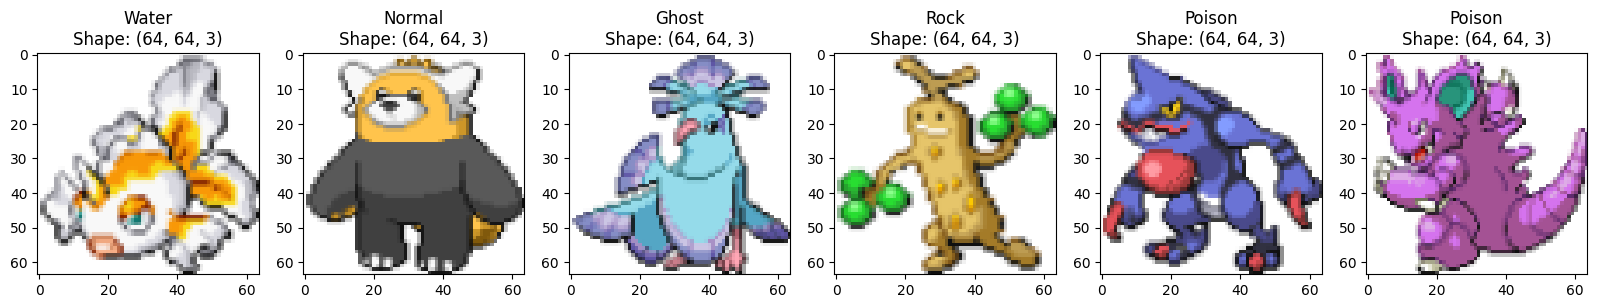

In [10]:
# dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset"
# poke_dataset = tf.data.Dataset.load(path=dataset_path, compression="GZIP")

poke_dataset = dataset_tf(
    df=df,
    dict_dataset=data_dict,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

# Visualize the dataset
visualize.plot_images_batch(dataset_tf=poke_dataset, n=6)

# 2. Model

In [11]:
# Create the model
# =====================================================================
u_net = build_unet(IMG_SIZE, NUM_CLASSES)
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = DiffusionModel(
    u_net, IMG_SIZE, NUM_CLASSES, T, BETA_START, BETA_END, s, SCHEDULER
)

# Compile the model
# =====================================================================
model.compile(loss=loss_fn, optimizer=optimizer)

## 2.1. Training

In [12]:
model.fit(poke_dataset, epochs=EPOCHS)
# model.fit(poke_dataset, epochs=EPOCHS, callbacks=[CustomCallback(model)]) # TODO INVESTIGAR CALLBACKS

Epoch 1/100


I0000 00:00:1711888560.626338     676 service.cc:145] XLA service 0x798688001350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1711888560.626360     676 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
I0000 00:00:1711888562.589211     975 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5197', 40 bytes spill stores, 40 bytes spill loads

I0000 00:00:1711888562.692308     977 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5197', 32 bytes spill stores, 32 bytes spill loads



  2/254 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - loss: 6.6463   

I0000 00:00:1711888573.633308     676 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


254/254 ━━━━━━━━━━━━━━━━━━━━ 45s 85ms/step - loss: 0.4826
Epoch 2/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - loss: 0.2136
Epoch 3/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - loss: 0.1851
Epoch 4/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - loss: 0.1714
Epoch 5/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 24s 93ms/step - loss: 0.1624
Epoch 6/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 24s 94ms/step - loss: 0.1559
Epoch 7/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 24s 94ms/step - loss: 0.1517
Epoch 8/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 24s 95ms/step - loss: 0.1483
Epoch 9/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 25s 97ms/step - loss: 0.1455
Epoch 10/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 25s 97ms/step - loss: 0.1429
Epoch 11/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 25s 97ms/step - loss: 0.1405
Epoch 12/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 25s 97ms/step - loss: 0.1385
Epoch 13/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 25s 97ms/step - loss: 0.1367
Epoch 14/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 25s 97ms/step - loss: 0.1349
Epoch 15/100
254/254 ━━━━━━

Generating sample 1/3


Sampling sprite: 100%|██████████| 999/999 [00:43<00:00, 22.76it/s]


Generating sample 2/3


Sampling sprite: 100%|██████████| 999/999 [00:41<00:00, 23.90it/s]


Generating sample 3/3


Sampling sprite: 100%|██████████| 999/999 [00:41<00:00, 24.00it/s]


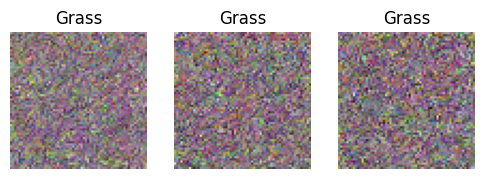

In [13]:
model.plot_samples(3, "Grass")

Generating sample 1/3


Sampling sprite: 100%|██████████| 999/999 [00:41<00:00, 23.91it/s]


Generating sample 2/3


Sampling sprite: 100%|██████████| 999/999 [00:40<00:00, 24.84it/s]


Generating sample 3/3


Sampling sprite: 100%|██████████| 999/999 [00:40<00:00, 24.55it/s]


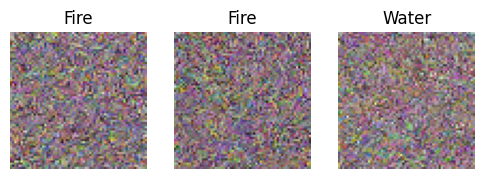

In [15]:
model.plot_samples(3)

In [16]:
# import gradio as gr

# poke_diffusion = gr.Interface(
#     fn=model.plot_samples,
#     inputs=gr.Slider(minimum=1, maximum=10, label="Number of samples"),
#     outputs=gr.Image(),
# )

# poke_diffusion.launch(share=True)

## 2.2. Save Model

Finalmente, se guardan los resultados finales del modelo de difusión en un fichero `.h5` para su posterior uso y visualización. TODO: MIRAR OTROS FORMATOS DE GUARDADO

TODO: INVESTIGAR OTROS FORMATOS DE GUARDADO (HDF5, PICKLE, ETC.)

In [ ]:
# Save the model function
# =====================================================================
def save_model(model: tf.keras.models.Model, model_name: str) -> None:
    """Saves the model

    :param model: The model to save
    :param model_name: The name of the model
    :return: None
    """

    # Save the model
    model_dir = "./diffusion_models/models/"
    os.makedirs(model_dir, exist_ok=True)
    if not os.path.exists(os.path.join(model_dir, f"{model_name}.h5")):
        model.save(os.path.join(model_dir, f"{model_name}.h5"))
        print(f"Model {model_name}, saved successfully!")
    else:
        print(f"Model {model_name}, already exists!")

In [ ]:
# Save the model
model_name = f"diffusion_{IMG_SIZE}_{BATCH_SIZE}_{EPOCHS}_{T}_{scheduler}_ddpm"

save_model(model, model_name)

[BACK TO TOP](#top)